# CVNNによる非線形歪補償
複素数を入力とする3層ANNによる補償

In [3]:
#import
import sys
import os
import time
import datetime
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

sys.path.append('../')
from pyopt.util import save_pickle, load_pickle

# 1. Preprocessing

## 1.1 データの整形

In [4]:
def data_shaping(input_signal, signal, max_tap, tap):
    """
    input_signal: 伝送前の信号
    signal: 伝送後の信号
    max_tap: 最大の同時入力シンボル数
    tap: 同時入力シンボル数
    
    signal = [x_0, x_1, ... , x_(n-1)]
      |
      |
      v
    x = [[x_0, x_1, ... , x_tap-1],
            [x_1, x_2, ..., x_tap],
                   .
                   .
                   .
            [x_(n-tap), x_(n-tap+1), ..., x(n-1)]]
      |
      |
      v
    x = [[i_0, q_0, i_1, q_1, ... , i_(tap-1), q_(tap-1)],
            [i_1, q_1, i_2, q_2, ... , i_tap, q_tap],
                   .
                   .
                   .
            [i_(n-tap), q_(n-tap), i_(n-tap+1), q_(n-tap+1), ..., i_(n-1), q_(n-1)]] (batch, input_dim) input_dim = tap * 2
    
    y  (batch, output_dim) output_dim = 2
    """
    
    x = np.zeros((len(input_signal) - (max_tap - 1), tap, 2), dtype=float)
    y = np.zeros((len(input_signal) - (max_tap - 1), 2), dtype=float)
    for i, j in enumerate(np.arange(max_tap // 2, len(input_signal) - max_tap // 2)):
        x[i, :, 0] = signal[j - tap // 2: j + tap // 2 + 1].real
        x[i, :, 1] = signal[j - tap // 2: j + tap // 2 + 1].imag
        y[i, 0] = input_signal[j].real
        y[i, 1] = input_signal[j].imag
    return x, y

In [5]:
#動作確認
tap = 1
max_tap = 51

df_dir = '../data/input/prbs.csv'
df = pd.read_csv(df_dir, index_col=0)  # dataframe読み込み
condition = (df['N']==13) & (df['itr']==1) & (df['form']=='RZ16QAM') & (df['n']==32) & (df['equalize']==False) & (df['baudrate']==28) & (df['PdBm']==1)
sgnl = load_pickle(df[condition].iloc[0]['data_path'])  # dataframeから条件と合う行を取得し,pickleの保存先(data_path)にアクセス
lc = sgnl.linear_compensation(500, sgnl.signal['x_500'])
x, y = data_shaping(sgnl.signal['x_0'][16::32], lc[16::32], max_tap, tap)  # ANNに入力できるようにデータを整形

print('x size: ', x.shape)
print('y size: ', y.shape)
print(x[0])
print(y[0])

x size:  (1998, 1, 2)
y size:  (1998, 2)
[[-53019.95429361  53670.26520552]]
[-70474.95606832  23491.65202277]


## 1.2 平均,標準偏差の計算

In [6]:
mean = np.mean(x)
std = np.std(x)

print('mean: ', mean)
print('std: ', std)

mean:  1138.625923374995
std:  52116.95097240129


# 2. Dataset定義

In [7]:
class Dataset(data.Dataset):
    def __init__(self, x, y, mean, std):
        self.x, self.y, self.mean, self.std = x, y, mean, std
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        
        x = (x - self.mean) / self.std
        y = (y - self.mean) / self.std
        
        x = torch.Tensor(x)
        y = torch.Tensor(y)
        
        x_i = x[:, 0]
        x_q = x[:, 1]
        y_i = y[0]
        y_q = y[1]
        return x_i, x_q, y_i, y_q

In [8]:
#動作確認
train_dataset = Dataset(x=x, y=y, mean=mean, std=std)

index = 0
x_i, x_q, y_i, y_q = train_dataset.__getitem__(index)
x_array = x_i.detach().numpy()

print('mean: ', np.mean(x_array))
print('std: ', np.std(x_array))
print(x_i)
print(y_i)

mean:  -1.039174
std:  0.0
tensor([-1.0392])
tensor(-1.3741)


In [9]:
batch_size = 100

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dataloaders_dict = {'train': train_dataloader}

# 3. Model定義

In [10]:
class CSigmoid(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x_i, x_q):
        x_i, x_q = x_i.clone(), x_q.clone()
        x_i, x_q = torch.sigmoid(x_i), torch.sigmoid(x_q)
        return x_i, x_q

In [11]:
class ZReLU(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x_i, x_q):
        x_i, x_q = x_i.clone(), x_q.clone()
        for i in range(x_i.shape[0]):
            for j in range(x_i.shape[1]):
                if x_i[i, j] < 0 or x_q[i, j] < 0:
                    x_i[i, j] = 0
                    x_q[i, j] = 0
        return x_i, x_q

In [12]:
class CReLU(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x_i, x_q):
        x_i, x_q = x_i.clone(), x_q.clone()
        x_i, x_q = F.relu(x_i), F.relu(x_q)
        return x_i, x_q

In [13]:
class modReLU(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.in_features = in_features
        self.b = torch.tensor(-math.sqrt(1 / in_features), requires_grad=True)
    
    def forward(self, x_i, x_q):
        x_i, x_q = x_i.clone(), x_q.clone()
        norm = torch.sqrt(x_i ** 2 + x_q ** 2)
        
        out_i = F.relu(norm + self.b) * x_i / norm
        out_q = F.relu(norm + self.b) * x_q / norm
        return out_i, out_q

In [14]:
class ComplexLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # 重み定義 Xavierの初期値
        k = 1 / in_features
        weight_i = torch.empty(out_features, in_features).uniform_(-math.sqrt(k), math.sqrt(k))
        self.weight_i = nn.Parameter(weight_i)
        weight_q = torch.empty(out_features, in_features).uniform_(-math.sqrt(k), math.sqrt(k))
        self.weight_q = nn.Parameter(weight_q)
        
        bias_i = torch.empty(out_features).uniform_(-k, k)
        self.bias_i = nn.Parameter(bias_i)
        bias_q = torch.empty(out_features).uniform_(-k, k)
        self.bias_q = nn.Parameter(bias_q)
        
    def forward(self, x_i, x_q):
        i = nn.functional.linear(x_i, self.weight_i) - nn.functional.linear(x_q, self.weight_q) + self.bias_i
        q = nn.functional.linear(x_i, self.weight_q) + nn.functional.linear(x_q, self.weight_i) + self.bias_q
        return i, q

In [15]:
class CVNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_neuron, activation):
        super().__init__()
        self.fc1 = ComplexLinear(input_dim, hidden_neuron)
        self.fc2 = ComplexLinear(hidden_neuron, output_dim)
        if activation == 'CSigmoid':
            self.activation = CSigmoid()
        elif activation == 'ZReLU':
            self.activation = ZReLU()
        elif activation == 'CReLU':
            self.activation = CReLU()
        elif activation == 'modReLU':
            self.activation = modReLU(input_dim)
    
    def forward(self, x_i, x_q):
        x_i, x_q = self.fc1(x_i, x_q)
        x_i, x_q = self.activation(x_i, x_q)
        x_i, x_q = self.fc2(x_i, x_q)
        return x_i, x_q

In [162]:
#動作確認
hidden_neuron = 300
activation = 'CSigmoid'
device = torch.device('cpu') # 'cuda' if torch.cuda.is_available() else 
print('Device available now:', device)

model = CVNN(input_dim=tap, output_dim=1, hidden_neuron=hidden_neuron, activation=activation).to(device)
for x_i, x_q, y_i, y_q in train_dataloader:
    out_i, out_q = model(x_i, x_q)
    print(out_i.shape)
    break

Device available now: cpu
torch.Size([100, 1])


# 4. train定義

In [16]:
def evm_score(x_i, x_q, y_i, y_q):
    tmp = 0
    for i in range(len(x_i)):
        tmp += ((x_i[i] - y_i[i]) ** 2 + (x_q[i] - y_q[i]) ** 2) / (y_i[i] ** 2 + y_q[i] ** 2)
    evm = torch.sqrt(tmp / len(x_i))
    return evm

In [17]:
class EVMLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x_i, x_q, y_i, y_q):
        return evm_score(x_i, x_q, y_i, y_q)

In [18]:
def train_model(device, model, dataloaders_dict, criterion, optimizer, epochs, epochs_section=None):
    for epoch in range(epochs):
        if epochs_section is not None:
            epoch += epochs_section[0]
            end_epoch = epochs_section[1]
        else:
            end_epoch = epochs
        
        start_time = time.time()
        
        for phase in dataloaders_dict.keys():
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            epoch_loss = 0.0
            epoch_evms = 0.0
            
            for x_i, x_q, y_i, y_q in dataloaders_dict[phase]:
                x_i, x_q = x_i.to(device), x_q.to(device)
                y_i, y_q = y_i.to(device), y_q.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    out_i, out_q = model(x_i, x_q)
                    loss = criterion(out_i, out_q, y_i, y_q)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item() * x_i.size(0)
                    epoch_evms += (evm_score(out_i, out_q, y_i, y_q)) ** 2 * x_i.size(0)
            
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_evm = torch.sqrt(epoch_evms / len(dataloaders_dict[phase].dataset)) * 100
            
            duration = str(datetime.timedelta(seconds=time.time() - start_time))[:7]
            print('{} | Epoch: {}/{} | {} Loss: {:.4} | EVM: {:.4}'.format(duration, epoch + 1, end_epoch, phase, epoch_loss, epoch_evm[0]))
    return model

In [163]:
#動作確認
epochs = 5
lr = 0.001
activation = 'CSigmoid'

criterion = EVMLoss()
optimizer = optim.Adam(params=model.parameters(), lr=lr)

train_model(device=device, model=model, dataloaders_dict=dataloaders_dict, criterion=criterion, optimizer=optimizer, epochs=epochs);

0:00:01 | Epoch: 1/5 | train Loss: 0.468 | EVM: 54.21
0:00:01 | Epoch: 2/5 | train Loss: 0.1319 | EVM: 13.51
0:00:01 | Epoch: 3/5 | train Loss: 0.09514 | EVM: 9.565
0:00:01 | Epoch: 4/5 | train Loss: 0.09092 | EVM: 9.147
0:00:01 | Epoch: 5/5 | train Loss: 0.088 | EVM: 8.825


In [166]:
#結果を保存しない
tap = 1
max_tap = 501
batch_size = 100
hidden_neuron = 300
epochs = 500
lr = 0.001
activation = 'CSigmoid'

device = torch.device('cpu') # 'cuda' if torch.cuda.is_available() else 
print('Device available now:', device)

df_dir = '../data/input/'
df0 = pd.read_csv(df_dir+'prbs.csv', index_col=0)

condition0 = (df0['N']==13) & (df0['itr']==1) & (df0['form']=='RZ16QAM') & (df0['n']==32) & (df0['equalize']==False) & (df0['baudrate']==28) & (df0['PdBm']==1)
sgnl0 = load_pickle(df0[condition0].iloc[0]['data_path'])
lc0 = sgnl0.linear_compensation(2500, sgnl0.signal['x_2500'])
x0, y0 = data_shaping(sgnl0.signal['x_0'][16::32], lc0[16::32], max_tap, tap)

condition1 = (df0['N']==17) & (df0['itr']==1) & (df0['form']=='RZ16QAM') & (df0['n']==32) & (df0['equalize']==False) & (df0['baudrate']==28) & (df0['PdBm']==1)
sgnl1 = load_pickle(df0[condition1].iloc[0]['data_path'])
lc1 = sgnl1.linear_compensation(2500, sgnl1.signal['x_2500'])
x1, y1 = data_shaping(sgnl1.signal['x_0'][16::32], lc1[16::32], max_tap, tap)

mean = np.mean(x0)
std = np.std(x0)

train_dataset = Dataset(x=x0, y=y0, mean=mean, std=std)
val_dataset = Dataset(x=x1, y=y1, mean=mean, std=std)

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

model = CVNN(input_dim=tap, output_dim=1, hidden_neuron=hidden_neuron, activation=activation).to(device)
criterion = EVMLoss()
optimizer = optim.Adam(params=model.parameters(), lr=lr)

model = train_model(device=device, model=model, dataloaders_dict=dataloaders_dict, criterion=criterion, optimizer=optimizer, epochs=epochs)

Device available now: cpu
0:00:00 | Epoch: 1/500 | train Loss: 0.5916 | EVM: 63.01
0:00:08 | Epoch: 1/500 | val Loss: 0.2245 | EVM: 22.48
0:00:00 | Epoch: 2/500 | train Loss: 0.1989 | EVM: 20.0
0:00:08 | Epoch: 2/500 | val Loss: 0.1985 | EVM: 19.93
0:00:00 | Epoch: 3/500 | train Loss: 0.1775 | EVM: 17.84
0:00:08 | Epoch: 3/500 | val Loss: 0.1805 | EVM: 18.11
0:00:00 | Epoch: 4/500 | train Loss: 0.1682 | EVM: 16.86
0:00:08 | Epoch: 4/500 | val Loss: 0.176 | EVM: 17.68
0:00:00 | Epoch: 5/500 | train Loss: 0.1658 | EVM: 16.65
0:00:08 | Epoch: 5/500 | val Loss: 0.1763 | EVM: 17.7
0:00:00 | Epoch: 6/500 | train Loss: 0.1653 | EVM: 16.59
0:00:08 | Epoch: 6/500 | val Loss: 0.1821 | EVM: 18.29
0:00:00 | Epoch: 7/500 | train Loss: 0.1652 | EVM: 16.58
0:00:08 | Epoch: 7/500 | val Loss: 0.1767 | EVM: 17.74
0:00:00 | Epoch: 8/500 | train Loss: 0.1727 | EVM: 17.3
0:00:08 | Epoch: 8/500 | val Loss: 0.1885 | EVM: 18.93
0:00:00 | Epoch: 9/500 | train Loss: 0.1699 | EVM: 17.07
0:00:08 | Epoch: 9/500 | 

0:00:15 | Epoch: 73/500 | val Loss: 0.1735 | EVM: 17.43
0:00:01 | Epoch: 74/500 | train Loss: 0.162 | EVM: 16.25
0:00:16 | Epoch: 74/500 | val Loss: 0.1702 | EVM: 17.1
0:00:01 | Epoch: 75/500 | train Loss: 0.1617 | EVM: 16.22
0:00:15 | Epoch: 75/500 | val Loss: 0.1779 | EVM: 17.87
0:00:01 | Epoch: 76/500 | train Loss: 0.1605 | EVM: 16.1
0:00:15 | Epoch: 76/500 | val Loss: 0.1841 | EVM: 18.49
0:00:01 | Epoch: 77/500 | train Loss: 0.1678 | EVM: 16.85
0:00:16 | Epoch: 77/500 | val Loss: 0.1741 | EVM: 17.49
0:00:01 | Epoch: 78/500 | train Loss: 0.1637 | EVM: 16.4
0:00:15 | Epoch: 78/500 | val Loss: 0.172 | EVM: 17.27
0:00:01 | Epoch: 79/500 | train Loss: 0.1622 | EVM: 16.26
0:00:15 | Epoch: 79/500 | val Loss: 0.1733 | EVM: 17.4
0:00:01 | Epoch: 80/500 | train Loss: 0.1611 | EVM: 16.14
0:00:15 | Epoch: 80/500 | val Loss: 0.1732 | EVM: 17.4
0:00:01 | Epoch: 81/500 | train Loss: 0.1599 | EVM: 16.03
0:00:15 | Epoch: 81/500 | val Loss: 0.1784 | EVM: 17.92
0:00:01 | Epoch: 82/500 | train Loss: 0

0:00:01 | Epoch: 145/500 | train Loss: 0.1613 | EVM: 16.18
0:00:15 | Epoch: 145/500 | val Loss: 0.1696 | EVM: 17.04
0:00:01 | Epoch: 146/500 | train Loss: 0.1607 | EVM: 16.18
0:00:15 | Epoch: 146/500 | val Loss: 0.1738 | EVM: 17.46
0:00:01 | Epoch: 147/500 | train Loss: 0.1624 | EVM: 16.37
0:00:15 | Epoch: 147/500 | val Loss: 0.1778 | EVM: 17.86
0:00:01 | Epoch: 148/500 | train Loss: 0.1667 | EVM: 16.72
0:00:15 | Epoch: 148/500 | val Loss: 0.1729 | EVM: 17.37
0:00:01 | Epoch: 149/500 | train Loss: 0.1603 | EVM: 16.1
0:00:15 | Epoch: 149/500 | val Loss: 0.1749 | EVM: 17.56
0:00:01 | Epoch: 150/500 | train Loss: 0.1577 | EVM: 15.79
0:00:15 | Epoch: 150/500 | val Loss: 0.1699 | EVM: 17.07
0:00:01 | Epoch: 151/500 | train Loss: 0.1591 | EVM: 15.95
0:00:15 | Epoch: 151/500 | val Loss: 0.1765 | EVM: 17.72
0:00:01 | Epoch: 152/500 | train Loss: 0.1607 | EVM: 16.11
0:00:15 | Epoch: 152/500 | val Loss: 0.1751 | EVM: 17.59
0:00:01 | Epoch: 153/500 | train Loss: 0.158 | EVM: 15.83
0:00:15 | Epoch

0:00:01 | Epoch: 216/500 | train Loss: 0.1601 | EVM: 16.06
0:00:15 | Epoch: 216/500 | val Loss: 0.1755 | EVM: 17.63
0:00:01 | Epoch: 217/500 | train Loss: 0.1654 | EVM: 16.64
0:00:15 | Epoch: 217/500 | val Loss: 0.173 | EVM: 17.38
0:00:01 | Epoch: 218/500 | train Loss: 0.1596 | EVM: 16.0
0:00:15 | Epoch: 218/500 | val Loss: 0.1763 | EVM: 17.71
0:00:01 | Epoch: 219/500 | train Loss: 0.1581 | EVM: 15.86
0:00:15 | Epoch: 219/500 | val Loss: 0.1744 | EVM: 17.51
0:00:01 | Epoch: 220/500 | train Loss: 0.158 | EVM: 15.87
0:00:15 | Epoch: 220/500 | val Loss: 0.1751 | EVM: 17.59
0:00:00 | Epoch: 221/500 | train Loss: 0.1573 | EVM: 15.79
0:00:14 | Epoch: 221/500 | val Loss: 0.1698 | EVM: 17.06
0:00:01 | Epoch: 222/500 | train Loss: 0.1575 | EVM: 15.8
0:00:14 | Epoch: 222/500 | val Loss: 0.1692 | EVM: 16.99
0:00:01 | Epoch: 223/500 | train Loss: 0.1619 | EVM: 16.25
0:00:14 | Epoch: 223/500 | val Loss: 0.1856 | EVM: 18.63
0:00:01 | Epoch: 224/500 | train Loss: 0.1613 | EVM: 16.17
0:00:15 | Epoch: 

0:00:01 | Epoch: 287/500 | train Loss: 0.1567 | EVM: 15.75
0:00:16 | Epoch: 287/500 | val Loss: 0.1733 | EVM: 17.4
0:00:01 | Epoch: 288/500 | train Loss: 0.1596 | EVM: 16.02
0:00:13 | Epoch: 288/500 | val Loss: 0.1696 | EVM: 17.03
0:00:01 | Epoch: 289/500 | train Loss: 0.1603 | EVM: 16.15
0:00:15 | Epoch: 289/500 | val Loss: 0.1822 | EVM: 18.3
0:00:01 | Epoch: 290/500 | train Loss: 0.1643 | EVM: 16.52
0:00:15 | Epoch: 290/500 | val Loss: 0.1739 | EVM: 17.47
0:00:01 | Epoch: 291/500 | train Loss: 0.1622 | EVM: 16.26
0:00:16 | Epoch: 291/500 | val Loss: 0.1694 | EVM: 17.01
0:00:01 | Epoch: 292/500 | train Loss: 0.1579 | EVM: 15.82
0:00:16 | Epoch: 292/500 | val Loss: 0.1723 | EVM: 17.31
0:00:01 | Epoch: 293/500 | train Loss: 0.1612 | EVM: 16.16
0:00:15 | Epoch: 293/500 | val Loss: 0.1694 | EVM: 17.01
0:00:01 | Epoch: 294/500 | train Loss: 0.1634 | EVM: 16.36
0:00:16 | Epoch: 294/500 | val Loss: 0.1761 | EVM: 17.69
0:00:01 | Epoch: 295/500 | train Loss: 0.1593 | EVM: 15.97
0:00:16 | Epoch

0:00:01 | Epoch: 358/500 | train Loss: 0.1606 | EVM: 16.11
0:00:15 | Epoch: 358/500 | val Loss: 0.171 | EVM: 17.17
0:00:01 | Epoch: 359/500 | train Loss: 0.1607 | EVM: 16.11
0:00:14 | Epoch: 359/500 | val Loss: 0.1735 | EVM: 17.42
0:00:01 | Epoch: 360/500 | train Loss: 0.1627 | EVM: 16.33
0:00:16 | Epoch: 360/500 | val Loss: 0.1742 | EVM: 17.5
0:00:01 | Epoch: 361/500 | train Loss: 0.1599 | EVM: 16.09
0:00:15 | Epoch: 361/500 | val Loss: 0.1713 | EVM: 17.21
0:00:01 | Epoch: 362/500 | train Loss: 0.158 | EVM: 15.85
0:00:15 | Epoch: 362/500 | val Loss: 0.1693 | EVM: 17.0
0:00:01 | Epoch: 363/500 | train Loss: 0.1569 | EVM: 15.76
0:00:16 | Epoch: 363/500 | val Loss: 0.1701 | EVM: 17.08
0:00:01 | Epoch: 364/500 | train Loss: 0.1579 | EVM: 15.84
0:00:16 | Epoch: 364/500 | val Loss: 0.1809 | EVM: 18.16
0:00:01 | Epoch: 365/500 | train Loss: 0.1624 | EVM: 16.28
0:00:16 | Epoch: 365/500 | val Loss: 0.1726 | EVM: 17.34
0:00:01 | Epoch: 366/500 | train Loss: 0.159 | EVM: 16.0
0:00:15 | Epoch: 36

0:00:01 | Epoch: 429/500 | train Loss: 0.1662 | EVM: 16.71
0:00:16 | Epoch: 429/500 | val Loss: 0.1716 | EVM: 17.23
0:00:01 | Epoch: 430/500 | train Loss: 0.1591 | EVM: 15.97
0:00:14 | Epoch: 430/500 | val Loss: 0.1702 | EVM: 17.09
0:00:01 | Epoch: 431/500 | train Loss: 0.1607 | EVM: 16.11
0:00:16 | Epoch: 431/500 | val Loss: 0.1715 | EVM: 17.22
0:00:01 | Epoch: 432/500 | train Loss: 0.1617 | EVM: 16.2
0:00:16 | Epoch: 432/500 | val Loss: 0.1706 | EVM: 17.14
0:00:01 | Epoch: 433/500 | train Loss: 0.161 | EVM: 16.18
0:00:15 | Epoch: 433/500 | val Loss: 0.179 | EVM: 17.98
0:00:01 | Epoch: 434/500 | train Loss: 0.1601 | EVM: 16.05
0:00:15 | Epoch: 434/500 | val Loss: 0.1798 | EVM: 18.05
0:00:01 | Epoch: 435/500 | train Loss: 0.162 | EVM: 16.28
0:00:15 | Epoch: 435/500 | val Loss: 0.1798 | EVM: 18.06
0:00:01 | Epoch: 436/500 | train Loss: 0.1639 | EVM: 16.45
0:00:15 | Epoch: 436/500 | val Loss: 0.1764 | EVM: 17.71
0:00:01 | Epoch: 437/500 | train Loss: 0.1667 | EVM: 16.7
0:00:16 | Epoch: 4

0:00:01 | Epoch: 500/500 | train Loss: 0.1597 | EVM: 16.01
0:00:16 | Epoch: 500/500 | val Loss: 0.1783 | EVM: 17.91


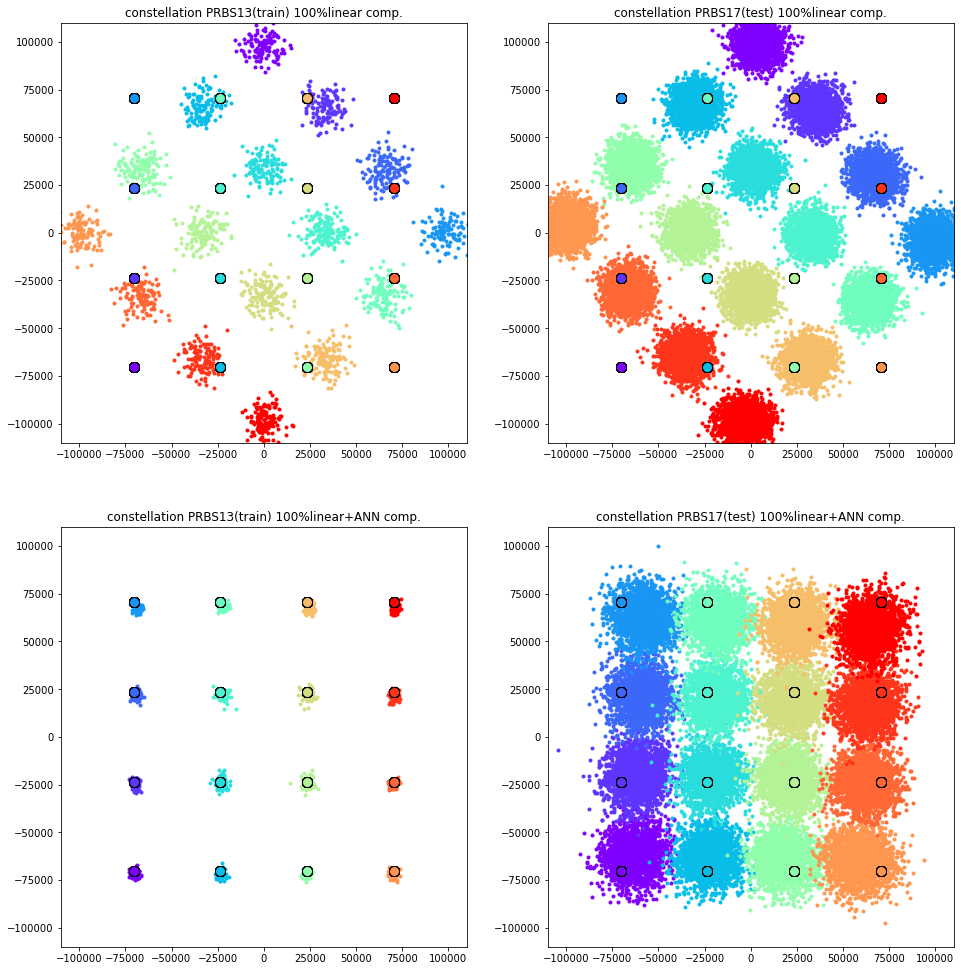

In [66]:
#可視化
y0 = y0 * std + mean
y0 = y0.astype(np.int32)
annc0_i = np.empty(0, float)
annc0_q = np.empty(0, float)
y0_i = np.empty(0, float)
y0_q = np.empty(0, float)
for x_i, x_q, y_i, y_q in dataloaders_dict['train']:
    x_i, x_q = x_i.to(device), x_q.to(device)
    out_i, out_q = model(x_i, x_q)
    annc0_i = np.append(annc0_i, out_i.detach().numpy() * std + mean)
    annc0_q = np.append(annc0_q, out_q.detach().numpy() * std + mean)
    y0_i = np.append(y0_i, (y_i.detach().numpy() * std + mean).astype(np.int32))
    y0_q = np.append(y0_q, (y_q.detach().numpy() * std + mean).astype(np.int32))
annc0 = annc0_i + annc0_q * 1j
y0 = y0_i + y0_q * 1j

annc1_i = np.empty(0, float)
annc1_q = np.empty(0, float)
y1_i = np.empty(0, float)
y1_q = np.empty(0, float)
for x_i, x_q, y_i, y_q in dataloaders_dict['val']:
    x_i, x_q = x_i.to(device), x_q.to(device)
    out_i, out_q = model(x_i, x_q)
    annc1_i = np.append(annc1_i, out_i.detach().numpy() * std + mean)
    annc1_q = np.append(annc1_q, out_q.detach().numpy() * std + mean)
    y1_i = np.append(y1_i, (y_i.detach().numpy() * std + mean).astype(np.int32))
    y1_q = np.append(y1_q, (y_q.detach().numpy() * std + mean).astype(np.int32))
annc1 = annc1_i + annc1_q * 1j
y1 = y1_i + y1_q * 1j

lim = 110000
cm = plt.get_cmap('rainbow', 16)

seq0 = sgnl0.signal['x_0'][16::32]
seq1 = sgnl1.signal['x_0'][16::32]
symbol, inverse, counts = np.unique(seq0, return_inverse=True, return_counts=True)
symbol_int = symbol.real.astype(np.int32) + symbol.imag.astype(np.int32) * 1j

fig = plt.figure(figsize=(16, 17))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

for i in range(len(symbol)):
    ax1.plot(lc0[16::32][seq0 == symbol[i]].real, lc0[16::32][seq0 == symbol[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=str(counts[i]))
for i in range(len(symbol)):
    ax1.plot(seq0[seq0 == symbol[i]].real, seq0[seq0 == symbol[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]], markersize=10, markeredgewidth=1, markeredgecolor='black')
ax1.set_title('constellation PRBS13(train) 100%linear comp.')
ax1.set_xlim(-lim, lim)
ax1.set_ylim(-lim, lim)

for i in range(len(symbol)):
    ax2.plot(lc1[16::32][seq1 == symbol[i]].real, lc1[16::32][seq1 == symbol[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=str(counts[i]))
for i in range(len(symbol)):
    ax2.plot(seq1[seq1 == symbol[i]].real, seq1[seq1 == symbol[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]], markersize=10, markeredgewidth=1, markeredgecolor='black')
ax2.set_title('constellation PRBS17(test) 100%linear comp.')
ax2.set_xlim(-lim, lim)
ax2.set_ylim(-lim, lim)

for i in range(len(symbol)):
    ax3.plot(annc0[y0 == symbol_int[i]].real, annc0[y0 == symbol_int[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
for i in range(len(symbol)):
    ax3.plot(y0[y0 == symbol_int[i]].real, y0[y0 == symbol_int[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]], markersize=10, markeredgewidth=1, markeredgecolor='black')
ax3.set_title('constellation PRBS13(train) 100%linear+ANN comp.')
ax3.set_xlim(-lim, lim)
ax3.set_ylim(-lim, lim)

for i in range(len(symbol)):
    ax4.plot(annc1[y1 == symbol_int[i]].real, annc1[y1 == symbol_int[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
for i in range(len(symbol)):
    ax4.plot(y1[y1 == symbol_int[i]].real, y1[y1 == symbol_int[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]], markersize=10, markeredgewidth=1, markeredgecolor='black')
ax4.set_title('constellation PRBS17(test) 100%linear+ANN comp.')
ax4.set_xlim(-lim, lim)
ax4.set_ylim(-lim, lim);

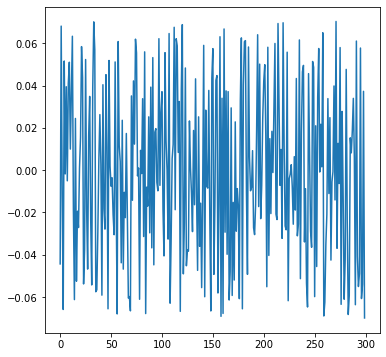

In [69]:
#重み可視化
weight = model.state_dict()['fc1.weight_i'].detach().numpy()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(weight[:, 0])

In [19]:
def train_ann(tap, PdBm):
    #結果と条件を../data/params/ANN.csvに保存する
    #tap = 1
    max_tap = 501
    batch_size = 100
    neuron = 300
    epochs = 500
    lr = 0.001
    activation = 'CReLU'

    device = torch.device('cpu') #'cuda' if torch.cuda.is_available() else 
    print('Device available now:', device)

    signal_type = 'image'

    form = 'RZ16QAM'  # 変調方式
    n = 32  # 1シンボルあたりのサンプリング数[/symbol]
    equalize = False  # 各シンボル数を均等にするか
    baudrate = 28  # ボーレート[GBaud]
    #PdBm = 1  # 平均入力光パワー[dBm]
    Ledfa = 100  # EDFAスパン[km]
    stepedfa = 30  # SSFMの繰り返し計算ステップ数
    gamma = 1.4  # 非線形係数[/W/km]
    D = 16  # 分散パラメータ[ps/nm/km]
    Alpha = 0.16  # 伝送損失[dB/km]
    NF = 4  # ASE雑音指数[dB]
    Lmax = 2500  # 伝送距離[km]
    ase = True  # ASE雑音を考慮するか

    if signal_type == 'prbs':
        N = 17  # PRBSの次数
        itr = 1  # PRBSの繰り返し回数
    elif signal_type == 'random':
        seed = 1234  # 乱数シード
        bit_num = 10000  # ビット長を指定
    elif signal_type == 'image':
        target_dir = 'train_0'
        step = 10  # =10 ---> (768, 1024) ---> (76, 102)
        image_number = '0'
        image_number_split = image_number.split(', ')
        ebtb = True  # 8B10Bを行うか

    # prbs.csv or random.csv or image.csvをpandasで読み込む
    t_df_dir = '../data/input/'
    t_df = pd.read_csv(t_df_dir+signal_type+'.csv', index_col=0)

    # if ANN.csv がある: pandasで読み込む if ANN.csvがない: 新しいDataFrameを作る
    l_df_dir = '../data/params/CVNN.csv'
    if os.path.exists(l_df_dir):
        l_df = pd.read_csv(l_df_dir, index_col=0)
    else:
        cols = ['tap', 'max_tap', 'batch_size', 'neuron', 'epochs', 'learning_rate', 'activation', 'N', 'itr', 'seed', 'bit_num', 'target_dir', 'step', 'image_number', 'ebtb', 'form', 'n', 'equalize', 'baudrate', 'PdBm', 'Ledfa', 'stepedfa', 'gamma', 'D', 'Alpha', 'NF', 'Lmax', 'ase', 'params_path', 'train_samples']
        l_df = pd.DataFrame(index=[], columns=cols)
        l_df.to_csv(l_df_dir)

    # 指定した学習条件と伝送条件
    l_condition = 'tap=='+str(tap)+'&max_tap=='+str(max_tap)+'&batch_size=='+str(batch_size)+'&neuron=='+str(neuron)+'&learning_rate=='+str(lr)+'&activation=="'+str(activation)+'"'
    t_condition = 'form=="'+str(form)+'"&n=='+str(n)+'&equalize=='+str(equalize)+'&baudrate=='+str(baudrate)+'&PdBm=='+str(PdBm)+'&Ledfa=='+str(Ledfa)+'&stepedfa=='+str(stepedfa)+'&\
                            gamma=='+str(gamma)+'&D=='+str(D)+'&Alpha=='+str(Alpha)+'&NF=='+str(NF)+'&ase=='+str(ase)
    if signal_type == 'prbs':
        condition_t = 'N=='+str(N)+'&itr=='+str(itr)
        condition_l = condition_t
        condition_list = [N, itr] + [None] * 6
    elif signal_type == 'random':
        condition_t = 'seed=='+str(seed)+'&bit_num=='+str(bit_num)
        condition_l = condition_t
        condition_list = [None] * 2 + [seed, bit_num] + [None] * 4
    elif signal_type == 'image':
        condition_t = 'target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=='+image_number_split[0]+'&ebtb=='+str(ebtb)
        condition_l = 'target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=="'+image_number+'"&ebtb=='+str(ebtb)
        condition_list = [None] * 4 + [target_dir, step, image_number, ebtb]

    # prbs.csv or random.csv or image.csvにおいて、指定した伝送条件を見たす行を抜き出す
    t_query = t_df.query(condition_t + '&' + t_condition)

    # ANN.csvにおいて、指定した条件を満たす行だけqueryとして抜き出す
    l_query = l_df.query(l_condition + '&' + condition_l + '&' + t_condition + '&Lmax=='+str(Lmax))

    # 後で異なる値が代入されるもの以外をSeriesにしてしまう(epochs, params_path, train_samplesだけNone)
    sr = pd.Series([tap, max_tap, batch_size, neuron, None, lr, activation] + condition_list + [form, n, equalize, baudrate, PdBm, Ledfa, stepedfa, gamma, D, Alpha, NF, Lmax, ase, None, None], index=l_df.columns)

    #if epochsを含む指定された条件を満たす結果がある: 何もしない
    if len(l_query) > 0 and l_query['epochs'].max() >= epochs:
        print('指定された条件の学習結果はすでに存在します')
    else:
        # if epochs以外の指定された条件を満たす結果がある: パラメータを読み込む if ない: 新しくモデルを作成する
        if len(l_query) > 0:
            index = l_query['epochs'].idxmax()
            trained_epochs = l_query['epochs'][index]
            model = CVNN(input_dim=tap, output_dim=1, hidden_neuron=neuron, activation=activation).to(device)
            model.load_state_dict(torch.load(l_query['params_path'][index]))
        else:
            trained_epochs = 0
            model = CVNN(input_dim=tap, output_dim=1, hidden_neuron=neuron, activation=activation).to(device)

        # if prbs.csv or random.csv or image.csvに指定した伝送条件がない or Lmax以外は満たすがLmaxだけ指定した条件未満: 何もしない if ある: 続ける
        if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
            print('指定された伝送条件の信号が存在しません')
        else:
            # 伝送信号を学習データに整形する
            sgnl_train = load_pickle(t_query.iloc[0]['data_path'])
            lc_train = sgnl_train.linear_compensation(Lmax, sgnl_train.signal['x_' + str(Lmax)])
            x_train, y_train = data_shaping(sgnl_train.signal['x_0'][n//2::n], lc_train[n//2::n], max_tap, tap)

            if signal_type == 'image' and len(image_number_split) > 1:
                for i in range(1, len(image_number_split)):
                    condition_t = 'target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=='+image_number_split[i]+'&ebtb=='+str(ebtb)
                    t_query = t_df.query(condition_t + '&' + t_condition)
                    if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
                        print('指定された伝送条件の信号が存在しません')
                        sys.exit()
                    sgnl_train = load_pickle(t_query.iloc[0]['data_path'])
                    lc_train = sgnl_train.linear_compensation(Lmax, sgnl_train.signal['x_' + str(Lmax)])
                    x_train_tmp, y_train_tmp = data_shaping(sgnl_train.signal['x_0'][n//2::n], lc_train[n//2::n], max_tap, tap)
                    x_train = np.concatenate([x_train, x_train_tmp])
                    y_train = np.concatenate([y_train, y_train_tmp])

            train_samples = len(x_train)

            # 平均,標準偏差の計算
            mean = np.mean(x_train)
            std = np.std(x_train)

            # dataset, dataloaderの作成
            train_dataset = Dataset(x=x_train, y=y_train, mean=mean, std=std)
            train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            dataloaders_dict = {'train': train_dataloader}

            # 損失関数, オプティマイザの作成
            criterion = EVMLoss()
            optimizer = optim.Adam(params=model.parameters(), lr=lr)

            # モデルのトレーニング(50epochsずつ学習し、50epochsずつパラメータを保存する)
            for i in range((epochs - trained_epochs) // 50):
                model = train_model(device=device, model=model, dataloaders_dict=dataloaders_dict, criterion=criterion, optimizer=optimizer, epochs=50, epochs_section=[trained_epochs+i*50, epochs])

                # 学習済みパラメータを保存し、ANN.csvに保存先を記入する
                l_df = pd.read_csv(l_df_dir, index_col=0)
                params_path = '../data/params/CVNN/params_' + str(len(l_df)).zfill(10) + '.pth'
                torch.save(model.state_dict(), params_path)
                sr[4] = trained_epochs + (i + 1) * 50
                sr[-2] = params_path
                sr[-1] = train_samples
                l_df = l_df.append(sr, ignore_index=True)
                l_df.to_csv(l_df_dir)

In [20]:
for tap in [1, 51, 101, 151, 201]:
    train_ann(tap, 1)

Device available now: cpu
0:00:45 | Epoch: 1/500 | train Loss: 0.1601 | EVM: 19.41
0:00:47 | Epoch: 2/500 | train Loss: 0.09266 | EVM: 9.647
0:00:36 | Epoch: 3/500 | train Loss: 0.08003 | EVM: 8.522
0:00:33 | Epoch: 4/500 | train Loss: 0.07668 | EVM: 8.224
0:00:45 | Epoch: 5/500 | train Loss: 0.0743 | EVM: 8.055
0:00:41 | Epoch: 6/500 | train Loss: 0.07308 | EVM: 7.974
0:00:42 | Epoch: 7/500 | train Loss: 0.07187 | EVM: 7.858
0:00:45 | Epoch: 8/500 | train Loss: 0.07077 | EVM: 7.793
0:00:50 | Epoch: 9/500 | train Loss: 0.07121 | EVM: 7.816
0:00:58 | Epoch: 10/500 | train Loss: 0.06858 | EVM: 7.617
0:00:57 | Epoch: 11/500 | train Loss: 0.06988 | EVM: 7.748
0:00:57 | Epoch: 12/500 | train Loss: 0.06964 | EVM: 7.752
0:00:59 | Epoch: 13/500 | train Loss: 0.06889 | EVM: 7.663
0:00:58 | Epoch: 14/500 | train Loss: 0.06943 | EVM: 7.725
0:00:58 | Epoch: 15/500 | train Loss: 0.06994 | EVM: 7.76
0:00:57 | Epoch: 16/500 | train Loss: 0.06863 | EVM: 7.654
0:00:57 | Epoch: 17/500 | train Loss: 0.06

0:00:50 | Epoch: 140/500 | train Loss: 0.06346 | EVM: 7.347
0:00:47 | Epoch: 141/500 | train Loss: 0.06314 | EVM: 7.352
0:00:44 | Epoch: 142/500 | train Loss: 0.06233 | EVM: 7.309
0:00:49 | Epoch: 143/500 | train Loss: 0.06233 | EVM: 7.316
0:00:51 | Epoch: 144/500 | train Loss: 0.06273 | EVM: 7.334
0:00:48 | Epoch: 145/500 | train Loss: 0.06215 | EVM: 7.281
0:00:48 | Epoch: 146/500 | train Loss: 0.06274 | EVM: 7.343
0:00:49 | Epoch: 147/500 | train Loss: 0.06297 | EVM: 7.321
0:00:42 | Epoch: 148/500 | train Loss: 0.0632 | EVM: 7.325
0:00:49 | Epoch: 149/500 | train Loss: 0.063 | EVM: 7.345
0:00:48 | Epoch: 150/500 | train Loss: 0.06239 | EVM: 7.286
0:00:39 | Epoch: 151/500 | train Loss: 0.06195 | EVM: 7.275
0:00:48 | Epoch: 152/500 | train Loss: 0.0618 | EVM: 7.283
0:00:46 | Epoch: 153/500 | train Loss: 0.06313 | EVM: 7.368
0:00:46 | Epoch: 154/500 | train Loss: 0.06267 | EVM: 7.302
0:00:47 | Epoch: 155/500 | train Loss: 0.06334 | EVM: 7.372
0:00:51 | Epoch: 156/500 | train Loss: 0.063

0:00:56 | Epoch: 278/500 | train Loss: 0.06056 | EVM: 7.208
0:00:58 | Epoch: 279/500 | train Loss: 0.06113 | EVM: 7.266
0:00:56 | Epoch: 280/500 | train Loss: 0.0609 | EVM: 7.227
0:00:58 | Epoch: 281/500 | train Loss: 0.06087 | EVM: 7.225
0:00:57 | Epoch: 282/500 | train Loss: 0.0609 | EVM: 7.214
0:00:58 | Epoch: 283/500 | train Loss: 0.06126 | EVM: 7.247
0:00:57 | Epoch: 284/500 | train Loss: 0.06016 | EVM: 7.19
0:01:00 | Epoch: 285/500 | train Loss: 0.06004 | EVM: 7.191
0:00:58 | Epoch: 286/500 | train Loss: 0.0607 | EVM: 7.249
0:00:55 | Epoch: 287/500 | train Loss: 0.06101 | EVM: 7.233
0:00:56 | Epoch: 288/500 | train Loss: 0.06082 | EVM: 7.25
0:00:56 | Epoch: 289/500 | train Loss: 0.06077 | EVM: 7.227
0:01:04 | Epoch: 290/500 | train Loss: 0.06132 | EVM: 7.277
0:01:03 | Epoch: 291/500 | train Loss: 0.06061 | EVM: 7.226
0:01:02 | Epoch: 292/500 | train Loss: 0.06128 | EVM: 7.238
0:01:03 | Epoch: 293/500 | train Loss: 0.06048 | EVM: 7.193
0:01:02 | Epoch: 294/500 | train Loss: 0.0612

0:00:57 | Epoch: 415/500 | train Loss: 0.0601 | EVM: 7.217
0:00:57 | Epoch: 416/500 | train Loss: 0.06057 | EVM: 7.24
0:00:57 | Epoch: 417/500 | train Loss: 0.05978 | EVM: 7.182
0:00:57 | Epoch: 418/500 | train Loss: 0.06049 | EVM: 7.227
0:00:56 | Epoch: 419/500 | train Loss: 0.0604 | EVM: 7.222
0:00:59 | Epoch: 420/500 | train Loss: 0.05978 | EVM: 7.185
0:00:58 | Epoch: 421/500 | train Loss: 0.06039 | EVM: 7.224
0:00:58 | Epoch: 422/500 | train Loss: 0.05988 | EVM: 7.209
0:00:57 | Epoch: 423/500 | train Loss: 0.05982 | EVM: 7.224
0:00:57 | Epoch: 424/500 | train Loss: 0.05978 | EVM: 7.211
0:00:58 | Epoch: 425/500 | train Loss: 0.05957 | EVM: 7.182
0:00:57 | Epoch: 426/500 | train Loss: 0.05987 | EVM: 7.214
0:01:04 | Epoch: 427/500 | train Loss: 0.06031 | EVM: 7.212
0:01:01 | Epoch: 428/500 | train Loss: 0.06032 | EVM: 7.235
0:01:04 | Epoch: 429/500 | train Loss: 0.06052 | EVM: 7.261
0:01:01 | Epoch: 430/500 | train Loss: 0.06005 | EVM: 7.234
0:01:04 | Epoch: 431/500 | train Loss: 0.05

0:01:06 | Epoch: 53/500 | train Loss: 0.06648 | EVM: 6.9
0:01:07 | Epoch: 54/500 | train Loss: 0.06581 | EVM: 6.821
0:01:07 | Epoch: 55/500 | train Loss: 0.06505 | EVM: 6.76
0:01:08 | Epoch: 56/500 | train Loss: 0.06452 | EVM: 6.711
0:01:07 | Epoch: 57/500 | train Loss: 0.06405 | EVM: 6.642
0:01:07 | Epoch: 58/500 | train Loss: 0.06373 | EVM: 6.618
0:01:08 | Epoch: 59/500 | train Loss: 0.06368 | EVM: 6.581
0:01:08 | Epoch: 60/500 | train Loss: 0.06287 | EVM: 6.522
0:01:07 | Epoch: 61/500 | train Loss: 0.06188 | EVM: 6.408
0:01:08 | Epoch: 62/500 | train Loss: 0.06162 | EVM: 6.396
0:01:09 | Epoch: 63/500 | train Loss: 0.06166 | EVM: 6.39
0:01:09 | Epoch: 64/500 | train Loss: 0.06088 | EVM: 6.307
0:01:08 | Epoch: 65/500 | train Loss: 0.06075 | EVM: 6.27
0:01:10 | Epoch: 66/500 | train Loss: 0.05978 | EVM: 6.212
0:01:08 | Epoch: 67/500 | train Loss: 0.05917 | EVM: 6.13
0:01:09 | Epoch: 68/500 | train Loss: 0.05948 | EVM: 6.159
0:01:09 | Epoch: 69/500 | train Loss: 0.05938 | EVM: 6.159
0:0

0:01:09 | Epoch: 191/500 | train Loss: 0.04228 | EVM: 4.463
0:01:08 | Epoch: 192/500 | train Loss: 0.04319 | EVM: 4.58
0:01:09 | Epoch: 193/500 | train Loss: 0.04222 | EVM: 4.471
0:01:09 | Epoch: 194/500 | train Loss: 0.04234 | EVM: 4.469
0:01:09 | Epoch: 195/500 | train Loss: 0.04256 | EVM: 4.495
0:01:10 | Epoch: 196/500 | train Loss: 0.0417 | EVM: 4.408
0:01:10 | Epoch: 197/500 | train Loss: 0.04244 | EVM: 4.48
0:01:09 | Epoch: 198/500 | train Loss: 0.04186 | EVM: 4.42
0:01:10 | Epoch: 199/500 | train Loss: 0.04259 | EVM: 4.528
0:01:09 | Epoch: 200/500 | train Loss: 0.04216 | EVM: 4.468
0:01:06 | Epoch: 201/500 | train Loss: 0.0415 | EVM: 4.365
0:01:09 | Epoch: 202/500 | train Loss: 0.04209 | EVM: 4.447
0:01:09 | Epoch: 203/500 | train Loss: 0.04222 | EVM: 4.431
0:01:08 | Epoch: 204/500 | train Loss: 0.04265 | EVM: 4.49
0:01:07 | Epoch: 205/500 | train Loss: 0.04186 | EVM: 4.434
0:01:08 | Epoch: 206/500 | train Loss: 0.04067 | EVM: 4.301
0:01:07 | Epoch: 207/500 | train Loss: 0.04118

0:01:09 | Epoch: 329/500 | train Loss: 0.0373 | EVM: 3.991
0:01:09 | Epoch: 330/500 | train Loss: 0.03708 | EVM: 3.947
0:01:08 | Epoch: 331/500 | train Loss: 0.03726 | EVM: 3.958
0:01:08 | Epoch: 332/500 | train Loss: 0.0369 | EVM: 3.909
0:01:09 | Epoch: 333/500 | train Loss: 0.03707 | EVM: 3.939
0:01:09 | Epoch: 334/500 | train Loss: 0.03722 | EVM: 3.981
0:01:09 | Epoch: 335/500 | train Loss: 0.03642 | EVM: 3.874
0:01:09 | Epoch: 336/500 | train Loss: 0.03696 | EVM: 3.937
0:01:10 | Epoch: 337/500 | train Loss: 0.03694 | EVM: 3.917
0:01:11 | Epoch: 338/500 | train Loss: 0.03707 | EVM: 3.913
0:01:07 | Epoch: 339/500 | train Loss: 0.03765 | EVM: 4.009
0:01:10 | Epoch: 340/500 | train Loss: 0.03706 | EVM: 3.935
0:01:08 | Epoch: 341/500 | train Loss: 0.03624 | EVM: 3.877
0:01:10 | Epoch: 342/500 | train Loss: 0.03755 | EVM: 4.002
0:01:10 | Epoch: 343/500 | train Loss: 0.03667 | EVM: 3.913
0:01:09 | Epoch: 344/500 | train Loss: 0.03688 | EVM: 3.92
0:01:09 | Epoch: 345/500 | train Loss: 0.03

0:01:09 | Epoch: 467/500 | train Loss: 0.03407 | EVM: 3.67
0:01:08 | Epoch: 468/500 | train Loss: 0.03407 | EVM: 3.642
0:01:09 | Epoch: 469/500 | train Loss: 0.03395 | EVM: 3.629
0:01:08 | Epoch: 470/500 | train Loss: 0.03348 | EVM: 3.587
0:01:09 | Epoch: 471/500 | train Loss: 0.03356 | EVM: 3.586
0:01:08 | Epoch: 472/500 | train Loss: 0.03332 | EVM: 3.572
0:01:08 | Epoch: 473/500 | train Loss: 0.03361 | EVM: 3.591
0:01:09 | Epoch: 474/500 | train Loss: 0.03417 | EVM: 3.665
0:01:09 | Epoch: 475/500 | train Loss: 0.03352 | EVM: 3.582
0:01:09 | Epoch: 476/500 | train Loss: 0.03333 | EVM: 3.583
0:01:09 | Epoch: 477/500 | train Loss: 0.03375 | EVM: 3.63
0:01:10 | Epoch: 478/500 | train Loss: 0.03412 | EVM: 3.665
0:01:09 | Epoch: 479/500 | train Loss: 0.03353 | EVM: 3.595
0:01:10 | Epoch: 480/500 | train Loss: 0.03381 | EVM: 3.631
0:01:10 | Epoch: 481/500 | train Loss: 0.0337 | EVM: 3.607
0:01:09 | Epoch: 482/500 | train Loss: 0.03416 | EVM: 3.649
0:01:09 | Epoch: 483/500 | train Loss: 0.03

0:01:10 | Epoch: 108/500 | train Loss: 0.1097 | EVM: 11.0
0:01:08 | Epoch: 109/500 | train Loss: 0.1095 | EVM: 10.98
0:01:08 | Epoch: 110/500 | train Loss: 0.1093 | EVM: 10.96
0:01:10 | Epoch: 111/500 | train Loss: 0.1091 | EVM: 10.94
0:01:09 | Epoch: 112/500 | train Loss: 0.1089 | EVM: 10.92
0:01:09 | Epoch: 113/500 | train Loss: 0.1086 | EVM: 10.89
0:01:10 | Epoch: 114/500 | train Loss: 0.1082 | EVM: 10.85
0:01:09 | Epoch: 115/500 | train Loss: 0.1083 | EVM: 10.86
0:01:09 | Epoch: 116/500 | train Loss: 0.108 | EVM: 10.82
0:01:08 | Epoch: 117/500 | train Loss: 0.1082 | EVM: 10.84
0:01:09 | Epoch: 118/500 | train Loss: 0.1077 | EVM: 10.8
0:01:10 | Epoch: 119/500 | train Loss: 0.1072 | EVM: 10.75
0:01:10 | Epoch: 120/500 | train Loss: 0.107 | EVM: 10.73
0:01:12 | Epoch: 121/500 | train Loss: 0.1075 | EVM: 10.78
0:01:10 | Epoch: 122/500 | train Loss: 0.1066 | EVM: 10.69
0:01:10 | Epoch: 123/500 | train Loss: 0.1066 | EVM: 10.69
0:01:10 | Epoch: 124/500 | train Loss: 0.1066 | EVM: 10.69
0

0:00:54 | Epoch: 246/500 | train Loss: 0.0823 | EVM: 8.258
0:01:05 | Epoch: 247/500 | train Loss: 0.08216 | EVM: 8.244
0:00:55 | Epoch: 248/500 | train Loss: 0.08214 | EVM: 8.242
0:01:06 | Epoch: 249/500 | train Loss: 0.082 | EVM: 8.23
0:01:03 | Epoch: 250/500 | train Loss: 0.08168 | EVM: 8.197
0:01:01 | Epoch: 251/500 | train Loss: 0.0819 | EVM: 8.22
0:01:02 | Epoch: 252/500 | train Loss: 0.08185 | EVM: 8.214
0:01:00 | Epoch: 253/500 | train Loss: 0.08142 | EVM: 8.169
0:01:00 | Epoch: 254/500 | train Loss: 0.08136 | EVM: 8.161
0:00:58 | Epoch: 255/500 | train Loss: 0.08154 | EVM: 8.183
0:01:02 | Epoch: 256/500 | train Loss: 0.08128 | EVM: 8.158
0:00:45 | Epoch: 257/500 | train Loss: 0.08126 | EVM: 8.153
0:01:03 | Epoch: 258/500 | train Loss: 0.08098 | EVM: 8.126
0:00:58 | Epoch: 259/500 | train Loss: 0.08091 | EVM: 8.118
0:01:03 | Epoch: 260/500 | train Loss: 0.08088 | EVM: 8.116
0:00:55 | Epoch: 261/500 | train Loss: 0.08072 | EVM: 8.098
0:00:53 | Epoch: 262/500 | train Loss: 0.08053

0:01:15 | Epoch: 384/500 | train Loss: 0.07323 | EVM: 7.346
0:01:15 | Epoch: 385/500 | train Loss: 0.07289 | EVM: 7.311
0:01:14 | Epoch: 386/500 | train Loss: 0.07308 | EVM: 7.333
0:01:13 | Epoch: 387/500 | train Loss: 0.07311 | EVM: 7.332
0:01:13 | Epoch: 388/500 | train Loss: 0.07305 | EVM: 7.326
0:01:14 | Epoch: 389/500 | train Loss: 0.07304 | EVM: 7.328
0:01:13 | Epoch: 390/500 | train Loss: 0.07301 | EVM: 7.326
0:01:13 | Epoch: 391/500 | train Loss: 0.07279 | EVM: 7.301
0:01:13 | Epoch: 392/500 | train Loss: 0.07294 | EVM: 7.317
0:01:13 | Epoch: 393/500 | train Loss: 0.07297 | EVM: 7.323
0:01:13 | Epoch: 394/500 | train Loss: 0.07278 | EVM: 7.301
0:01:14 | Epoch: 395/500 | train Loss: 0.07274 | EVM: 7.299
0:01:13 | Epoch: 396/500 | train Loss: 0.07266 | EVM: 7.29
0:01:13 | Epoch: 397/500 | train Loss: 0.07252 | EVM: 7.274
0:01:13 | Epoch: 398/500 | train Loss: 0.07279 | EVM: 7.303
0:01:11 | Epoch: 399/500 | train Loss: 0.07285 | EVM: 7.309
0:01:11 | Epoch: 400/500 | train Loss: 0.

0:01:12 | Epoch: 22/500 | train Loss: 0.1361 | EVM: 13.64
0:01:13 | Epoch: 23/500 | train Loss: 0.1354 | EVM: 13.57
0:01:12 | Epoch: 24/500 | train Loss: 0.1348 | EVM: 13.51
0:01:14 | Epoch: 25/500 | train Loss: 0.1339 | EVM: 13.43
0:01:12 | Epoch: 26/500 | train Loss: 0.1324 | EVM: 13.27
0:01:13 | Epoch: 27/500 | train Loss: 0.132 | EVM: 13.23
0:01:12 | Epoch: 28/500 | train Loss: 0.1317 | EVM: 13.2
0:01:13 | Epoch: 29/500 | train Loss: 0.1303 | EVM: 13.06
0:01:13 | Epoch: 30/500 | train Loss: 0.1301 | EVM: 13.05
0:01:13 | Epoch: 31/500 | train Loss: 0.1287 | EVM: 12.9
0:01:12 | Epoch: 32/500 | train Loss: 0.1286 | EVM: 12.89
0:01:13 | Epoch: 33/500 | train Loss: 0.1278 | EVM: 12.8
0:01:13 | Epoch: 34/500 | train Loss: 0.1277 | EVM: 12.8
0:01:13 | Epoch: 35/500 | train Loss: 0.1267 | EVM: 12.7
0:01:12 | Epoch: 36/500 | train Loss: 0.1263 | EVM: 12.66
0:01:13 | Epoch: 37/500 | train Loss: 0.1259 | EVM: 12.62
0:01:13 | Epoch: 38/500 | train Loss: 0.1254 | EVM: 12.57
0:01:13 | Epoch: 39/

0:01:04 | Epoch: 163/500 | train Loss: 0.1011 | EVM: 10.13
0:01:05 | Epoch: 164/500 | train Loss: 0.1009 | EVM: 10.11
0:01:04 | Epoch: 165/500 | train Loss: 0.1007 | EVM: 10.09
0:01:06 | Epoch: 166/500 | train Loss: 0.101 | EVM: 10.12
0:01:00 | Epoch: 167/500 | train Loss: 0.1011 | EVM: 10.13
0:00:56 | Epoch: 168/500 | train Loss: 0.1011 | EVM: 10.14
0:00:43 | Epoch: 169/500 | train Loss: 0.1013 | EVM: 10.15
0:01:06 | Epoch: 170/500 | train Loss: 0.1004 | EVM: 10.06
0:01:01 | Epoch: 171/500 | train Loss: 0.1002 | EVM: 10.04
0:01:04 | Epoch: 172/500 | train Loss: 0.1011 | EVM: 10.13
0:01:01 | Epoch: 173/500 | train Loss: 0.1002 | EVM: 10.04
0:01:06 | Epoch: 174/500 | train Loss: 0.1001 | EVM: 10.03
0:01:09 | Epoch: 175/500 | train Loss: 0.1002 | EVM: 10.04
0:01:08 | Epoch: 176/500 | train Loss: 0.1 | EVM: 10.02
0:01:08 | Epoch: 177/500 | train Loss: 0.1 | EVM: 10.03
0:01:04 | Epoch: 178/500 | train Loss: 0.09974 | EVM: 9.994
0:01:06 | Epoch: 179/500 | train Loss: 0.09997 | EVM: 10.02
0:

0:01:02 | Epoch: 301/500 | train Loss: 0.08896 | EVM: 8.916
0:01:04 | Epoch: 302/500 | train Loss: 0.08871 | EVM: 8.891
0:01:07 | Epoch: 303/500 | train Loss: 0.08851 | EVM: 8.87
0:01:04 | Epoch: 304/500 | train Loss: 0.08847 | EVM: 8.866
0:01:03 | Epoch: 305/500 | train Loss: 0.08853 | EVM: 8.874
0:01:07 | Epoch: 306/500 | train Loss: 0.08822 | EVM: 8.842
0:01:05 | Epoch: 307/500 | train Loss: 0.08853 | EVM: 8.872
0:01:03 | Epoch: 308/500 | train Loss: 0.0885 | EVM: 8.868
0:01:05 | Epoch: 309/500 | train Loss: 0.08833 | EVM: 8.852
0:01:05 | Epoch: 310/500 | train Loss: 0.08824 | EVM: 8.843
0:01:06 | Epoch: 311/500 | train Loss: 0.08808 | EVM: 8.828
0:01:04 | Epoch: 312/500 | train Loss: 0.08797 | EVM: 8.815
0:01:06 | Epoch: 313/500 | train Loss: 0.08803 | EVM: 8.822
0:01:05 | Epoch: 314/500 | train Loss: 0.08799 | EVM: 8.818
0:01:06 | Epoch: 315/500 | train Loss: 0.0878 | EVM: 8.799
0:01:03 | Epoch: 316/500 | train Loss: 0.08793 | EVM: 8.814
0:01:05 | Epoch: 317/500 | train Loss: 0.08

0:01:03 | Epoch: 439/500 | train Loss: 0.07896 | EVM: 7.915
0:01:03 | Epoch: 440/500 | train Loss: 0.07885 | EVM: 7.903
0:01:02 | Epoch: 441/500 | train Loss: 0.07851 | EVM: 7.87
0:01:03 | Epoch: 442/500 | train Loss: 0.07896 | EVM: 7.915
0:01:06 | Epoch: 443/500 | train Loss: 0.07874 | EVM: 7.893
0:01:05 | Epoch: 444/500 | train Loss: 0.07855 | EVM: 7.872
0:01:05 | Epoch: 445/500 | train Loss: 0.07868 | EVM: 7.886
0:01:07 | Epoch: 446/500 | train Loss: 0.07834 | EVM: 7.852
0:01:06 | Epoch: 447/500 | train Loss: 0.07868 | EVM: 7.886
0:01:04 | Epoch: 448/500 | train Loss: 0.07843 | EVM: 7.859
0:01:05 | Epoch: 449/500 | train Loss: 0.07849 | EVM: 7.869
0:01:05 | Epoch: 450/500 | train Loss: 0.07853 | EVM: 7.872
0:00:57 | Epoch: 451/500 | train Loss: 0.07807 | EVM: 7.826
0:01:04 | Epoch: 452/500 | train Loss: 0.07822 | EVM: 7.841
0:01:04 | Epoch: 453/500 | train Loss: 0.07816 | EVM: 7.835
0:01:03 | Epoch: 454/500 | train Loss: 0.0781 | EVM: 7.829
0:01:04 | Epoch: 455/500 | train Loss: 0.0

0:01:05 | Epoch: 79/500 | train Loss: 0.1089 | EVM: 10.92
0:01:00 | Epoch: 80/500 | train Loss: 0.109 | EVM: 10.93
0:00:52 | Epoch: 81/500 | train Loss: 0.1093 | EVM: 10.95
0:01:05 | Epoch: 82/500 | train Loss: 0.1084 | EVM: 10.87
0:01:06 | Epoch: 83/500 | train Loss: 0.1083 | EVM: 10.86
0:00:53 | Epoch: 84/500 | train Loss: 0.1081 | EVM: 10.83
0:01:07 | Epoch: 85/500 | train Loss: 0.1086 | EVM: 10.89
0:01:09 | Epoch: 86/500 | train Loss: 0.1079 | EVM: 10.81
0:01:07 | Epoch: 87/500 | train Loss: 0.1073 | EVM: 10.76
0:01:06 | Epoch: 88/500 | train Loss: 0.1077 | EVM: 10.8
0:01:08 | Epoch: 89/500 | train Loss: 0.1077 | EVM: 10.79
0:01:02 | Epoch: 90/500 | train Loss: 0.1066 | EVM: 10.68
0:01:03 | Epoch: 91/500 | train Loss: 0.1072 | EVM: 10.75
0:01:07 | Epoch: 92/500 | train Loss: 0.1067 | EVM: 10.7
0:01:08 | Epoch: 93/500 | train Loss: 0.1072 | EVM: 10.75
0:00:55 | Epoch: 94/500 | train Loss: 0.1066 | EVM: 10.69
0:01:07 | Epoch: 95/500 | train Loss: 0.1062 | EVM: 10.65
0:01:06 | Epoch: 

0:01:03 | Epoch: 218/500 | train Loss: 0.09233 | EVM: 9.256
0:01:00 | Epoch: 219/500 | train Loss: 0.09248 | EVM: 9.274
0:01:06 | Epoch: 220/500 | train Loss: 0.09235 | EVM: 9.261
0:01:06 | Epoch: 221/500 | train Loss: 0.09246 | EVM: 9.272
0:01:00 | Epoch: 222/500 | train Loss: 0.09253 | EVM: 9.276
0:01:05 | Epoch: 223/500 | train Loss: 0.09181 | EVM: 9.205
0:01:04 | Epoch: 224/500 | train Loss: 0.09185 | EVM: 9.205
0:01:03 | Epoch: 225/500 | train Loss: 0.09192 | EVM: 9.213
0:01:05 | Epoch: 226/500 | train Loss: 0.09172 | EVM: 9.194
0:00:54 | Epoch: 227/500 | train Loss: 0.09206 | EVM: 9.23
0:01:05 | Epoch: 228/500 | train Loss: 0.09181 | EVM: 9.204
0:00:56 | Epoch: 229/500 | train Loss: 0.09164 | EVM: 9.187
0:01:04 | Epoch: 230/500 | train Loss: 0.09118 | EVM: 9.141
0:01:00 | Epoch: 231/500 | train Loss: 0.0914 | EVM: 9.165
0:01:02 | Epoch: 232/500 | train Loss: 0.09118 | EVM: 9.139
0:01:04 | Epoch: 233/500 | train Loss: 0.09102 | EVM: 9.125
0:01:06 | Epoch: 234/500 | train Loss: 0.0

0:01:02 | Epoch: 356/500 | train Loss: 0.0836 | EVM: 8.381
0:01:04 | Epoch: 357/500 | train Loss: 0.08354 | EVM: 8.375
0:00:58 | Epoch: 358/500 | train Loss: 0.08334 | EVM: 8.356
0:00:57 | Epoch: 359/500 | train Loss: 0.08318 | EVM: 8.34
0:01:05 | Epoch: 360/500 | train Loss: 0.08314 | EVM: 8.335
0:01:04 | Epoch: 361/500 | train Loss: 0.08272 | EVM: 8.292
0:00:58 | Epoch: 362/500 | train Loss: 0.08292 | EVM: 8.314
0:00:59 | Epoch: 363/500 | train Loss: 0.08319 | EVM: 8.339
0:00:58 | Epoch: 364/500 | train Loss: 0.08322 | EVM: 8.342
0:01:04 | Epoch: 365/500 | train Loss: 0.08292 | EVM: 8.314
0:01:04 | Epoch: 366/500 | train Loss: 0.08259 | EVM: 8.282
0:01:04 | Epoch: 367/500 | train Loss: 0.08258 | EVM: 8.278
0:01:05 | Epoch: 368/500 | train Loss: 0.08299 | EVM: 8.322
0:01:04 | Epoch: 369/500 | train Loss: 0.08293 | EVM: 8.316
0:00:57 | Epoch: 370/500 | train Loss: 0.08249 | EVM: 8.273
0:00:56 | Epoch: 371/500 | train Loss: 0.08247 | EVM: 8.27
0:01:05 | Epoch: 372/500 | train Loss: 0.08

0:01:05 | Epoch: 493/500 | train Loss: 0.07716 | EVM: 7.736
0:01:06 | Epoch: 494/500 | train Loss: 0.0774 | EVM: 7.762
0:01:06 | Epoch: 495/500 | train Loss: 0.07701 | EVM: 7.723
0:01:04 | Epoch: 496/500 | train Loss: 0.07729 | EVM: 7.751
0:01:05 | Epoch: 497/500 | train Loss: 0.07718 | EVM: 7.741
0:01:07 | Epoch: 498/500 | train Loss: 0.07709 | EVM: 7.73
0:00:54 | Epoch: 499/500 | train Loss: 0.07655 | EVM: 7.676
0:01:06 | Epoch: 500/500 | train Loss: 0.077 | EVM: 7.72
